In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import recordlinkage
from numpy.random import randint
import matplotlib.dates as mdates
from IPython.display import display, HTML

In [2]:
original_data = pd.read_excel('open_data_covid20_21.xlsx')

In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   RecordId                      2797 non-null   int64         
 1   Age                           2797 non-null   int64         
 2   AgeDay                        2797 non-null   int64         
 3   AgeMonth                      2797 non-null   int64         
 4   CloseContactRecordId          0 non-null      float64       
 5   DateOfFirstPositiveLabResult  2797 non-null   object        
 6   DateOfHospitalisation         2797 non-null   datetime64[ns]
 7   DateOfDischarge               2797 non-null   datetime64[ns]
 8   DateOfOnset                   0 non-null      float64       
 9   Gender                        2797 non-null   object        
 10  Hospitalisation               2797 non-null   object        
 11  IntensiveCare                 

In [4]:
original_data.Age.describe()

count    2797.000000
mean       65.883447
std        19.907224
min         0.000000
25%        56.000000
50%        70.000000
75%        81.000000
max       100.000000
Name: Age, dtype: float64

In [5]:
# create a new attribute with the number of hospitalisation days
original_data['HospitalisationDays'] = original_data['DateOfDischarge'] - original_data['DateOfHospitalisation']

In [6]:
# transform "HospitalisationDays" into number of days
original_data['HospitalisationDays'] = original_data['HospitalisationDays'].dt.days

In [7]:
# Remove attributes with no relevant information for this use case.
del original_data['Hospitalisation']
del original_data['AgeDay']
del original_data['CloseContactRecordId']
del original_data['DateOfDischarge']
del original_data['DateOfOnset']
del original_data['PlaceOfInfection']

In [8]:
# Convert the 'DateOfFirstPositiveLabResult' column to datetime
original_data['DateOfFirstPositiveLabResult'] = pd.to_datetime(original_data['DateOfFirstPositiveLabResult'])

# Drop rows where the year is 2022 or later
original_data = original_data[original_data['DateOfFirstPositiveLabResult'] < '2022-01-01']


In [9]:
original_data.shape

(2738, 33)

In [10]:
original_data['DateOfFirstPositiveLabResult'].max()

Timestamp('2021-12-31 12:24:00')

### Risk of re-identification in the original data

In [11]:
def risk_kanonymity(qi, data):
    # Group by the quasi-identifiers and count occurrences
    fk = data.groupby(qi, dropna=False)[qi[0]].transform('size')
    
    # Calculate the number of unique groups with only one occurrence
    fk1_count = (fk == 1).sum()
    
    # Calculate the risk as the percentage of rows in unique groups
    risk_percentage = (fk1_count * 100) / len(data)
    
    # Print the results
    print(f"risk = {risk_percentage:.2f}%; fk1 = {fk1_count}")

In [12]:
risk_kanonymity(['Age', 'Gender'], original_data), 
risk_kanonymity(['Age', 'Gender', 'Outcome'], original_data),
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays'], original_data)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'Outcome'], original_data)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult'], original_data)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome'], original_data)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome'], original_data)

risk = 0.55%; fk1 = 15
risk = 4.46%; fk1 = 122
risk = 53.25%; fk1 = 1458
risk = 70.31%; fk1 = 1925
risk = 96.46%; fk1 = 2641
risk = 97.44%; fk1 = 2668
risk = 99.74%; fk1 = 2731


### Risk of re-identification in the death subset

In [13]:
deaths = original_data[original_data['Outcome'] == 'D'].copy() 
print("Nr of obs: ", len(deaths))

Nr of obs:  558


In [14]:
risk_kanonymity(['Age', 'Gender'], deaths), 
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays'], deaths)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult'], deaths)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult'], deaths)

risk = 4.48%; fk1 = 25
risk = 78.85%; fk1 = 440
risk = 100.00%; fk1 = 558
risk = 100.00%; fk1 = 558


### Risk of re-identification in the nursing home subset

In [15]:
nursehome = original_data[original_data['Outcome'] == 'N'].copy()
print("Nr of obs: ", len(nursehome))

Nr of obs:  68


In [16]:
risk_kanonymity(['Age', 'Gender'], nursehome), 
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays'], nursehome)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult'], nursehome)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult'], nursehome)

risk = 38.24%; fk1 = 26
risk = 100.00%; fk1 = 68
risk = 100.00%; fk1 = 68
risk = 100.00%; fk1 = 68


### Risk of re-identification in the intensive care subset

In [17]:
intensivecare = original_data[original_data['IntensiveCare'] == 'Y']
print("Nr of obs: ", len(intensivecare))

Nr of obs:  867


In [18]:
risk_kanonymity(['Age', 'Gender'], intensivecare), 
risk_kanonymity(['Age', 'Gender', 'Outcome'], intensivecare),
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays'], intensivecare)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'Outcome'], intensivecare)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult'], intensivecare)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome'], intensivecare)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome'], intensivecare)

risk = 3.46%; fk1 = 30
risk = 16.26%; fk1 = 141
risk = 84.20%; fk1 = 730
risk = 92.73%; fk1 = 804
risk = 100.00%; fk1 = 867
risk = 100.00%; fk1 = 867
risk = 100.00%; fk1 = 867


### Risk of re-identification in the newborn subset

In [102]:
babies = original_data[original_data['Age']<1]
print("Nr of obs: ", len(babies))

Nr of obs:  19


In [103]:
risk_kanonymity(['Age', 'Gender'], babies), 
risk_kanonymity(['Age', 'Gender', 'Outcome'], babies),
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays'], babies)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'Outcome'], babies)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult'], babies)
risk_kanonymity(['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome'], babies)
risk_kanonymity(['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome'], babies)

risk = 0.00%; fk1 = 0
risk = 5.26%; fk1 = 1
risk = 68.42%; fk1 = 13
risk = 68.42%; fk1 = 13
risk = 100.00%; fk1 = 19
risk = 100.00%; fk1 = 19
risk = 100.00%; fk1 = 19


In [104]:
babies

,RecordId,Age,AgeMonth,DateOfFirstPositiveLabResult,DateOfHospitalisation,Gender,IntensiveCare,Outcome,CANC,CEREBROVASCULAR,...,PreconditionOther,CODVISIT,ECMO,HFO,NIV,IMV,ABADMIN,AVADMIN,CTADMIN,HospitalisationDays
2309,2235676,0,11,2020-12-03 11:29:00,2020-10-06,F,Y,H,N,N,...,N,Y,N,N,Y,Y,Y,N,N,78
2324,2243158,0,3,2020-04-06 13:42:00,2020-04-06,M,N,H,Y,N,...,N,Y,N,N,N,N,N,N,N,1
2384,2258857,0,8,2020-10-17 20:53:00,2020-10-22,F,N,H,N,N,...,N,Y,N,N,N,N,Y,Y,N,4
2387,2259109,0,1,2020-04-21 11:07:00,2020-03-25,F,N,H,Y,N,...,N,Y,N,N,N,N,Y,N,Y,33
2457,2296287,0,1,2020-10-10 18:15:00,2020-10-11,F,N,H,N,N,...,N,Y,N,N,N,N,Y,N,N,2
2463,2298939,0,1,2020-09-22 16:43:00,2020-09-23,M,N,H,N,N,...,N,Y,N,N,N,N,N,N,Y,5
2475,2301785,0,1,2020-11-20 13:20:00,2020-11-20,M,N,H,N,N,...,N,Y,N,N,N,N,N,N,N,3
2486,2303892,0,0,2020-10-18 09:54:00,2020-10-18,M,N,H,N,N,...,N,Y,N,N,N,N,Y,N,N,10
2543,2309506,0,2,2020-11-22 15:51:00,2020-11-17,F,N,H,N,N,...,N,Y,N,N,N,N,Y,N,N,6
2546,2309764,0,0,2020-11-20 11:17:00,2020-11-18,M,N,H,N,N,...,N,Y,N,N,N,N,N,N,N,4


In [22]:
# Using AgeMonth instead of Age
risk_kanonymity(['AgeMonth', 'Gender'], babies), 
risk_kanonymity(['AgeMonth', 'Gender', 'Outcome'], babies),
risk_kanonymity(['AgeMonth', 'Gender', 'HospitalisationDays'], babies)
risk_kanonymity(['AgeMonth', 'Gender', 'HospitalisationDays', 'Outcome'], babies)
risk_kanonymity(['AgeMonth', 'Gender', 'DateOfFirstPositiveLabResult'], babies)
risk_kanonymity(['AgeMonth', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome'], babies)
risk_kanonymity(['AgeMonth', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome'], babies)

risk = 26.32%; fk1 = 5
risk = 26.32%; fk1 = 5
risk = 89.47%; fk1 = 17
risk = 89.47%; fk1 = 17
risk = 100.00%; fk1 = 19
risk = 100.00%; fk1 = 19
risk = 100.00%; fk1 = 19


## Transformations

In [23]:
original_data_re = original_data.copy()

### Transformation - aggregation of re-incident hospitalisation cases

In [24]:
original_data_re['ReincidenceHospitalisation'] = original_data_re.groupby(['RecordId'])['DateOfHospitalisation'].transform(len)

In [25]:
original_data_re[original_data_re['ReincidenceHospitalisation'] > 1]

,RecordId,Age,AgeMonth,DateOfFirstPositiveLabResult,DateOfHospitalisation,Gender,IntensiveCare,Outcome,CANC,CEREBROVASCULAR,...,CODVISIT,ECMO,HFO,NIV,IMV,ABADMIN,AVADMIN,CTADMIN,HospitalisationDays,ReincidenceHospitalisation
8,5727,32,392,2020-11-13 12:30:00,2020-11-16,F,N,H,N,N,...,Y,N,N,N,N,N,N,Y,2,2
9,5727,32,392,2020-11-13 12:30:00,2020-11-20,F,Y,H,N,N,...,Y,N,Y,Y,N,Y,N,Y,10,2
206,146080,75,923,2020-10-20 12:04:00,2020-10-20,F,N,H,N,N,...,Y,N,N,N,N,N,N,Y,3,2
207,146080,75,923,2020-10-20 12:04:00,2020-10-26,F,N,H,N,Y,...,Y,N,N,N,N,N,N,Y,8,2
279,182120,77,939,2020-12-02 22:12:00,2020-12-03,F,N,H,N,N,...,Y,N,N,N,N,N,N,N,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,2306944,84,1031,2020-11-02 19:37:00,2020-11-09,M,N,H,Y,Y,...,Y,N,N,N,N,N,N,Y,16,2
2527,2308335,74,902,2020-11-10 13:19:00,2020-11-10,M,N,H,N,N,...,Y,N,N,N,N,N,N,Y,3,2
2528,2308335,74,902,2020-11-10 13:19:00,2020-11-20,M,Y,H,N,N,...,Y,N,N,N,N,N,N,N,5,2
2766,2355257,60,736,2021-08-26 14:43:00,2021-08-24,M,Y,H,N,N,...,Y,N,Y,Y,N,Y,N,Y,14,2


In [26]:
97/2+1

49.5

In [27]:
original_data_re = original_data_re.loc[original_data_re.groupby('RecordId').RecordId.idxmin()].reset_index(drop=True)

In [28]:
original_data_re.shape

(2688, 34)

In [29]:
def risk_fk_table(sets_of_qis, original_data, modified_data):
    results = []
    
    for qi_set in sets_of_qis:
        # Calculate risk of original data
        fk_before = original_data.groupby(qi_set, dropna=False)[qi_set[0]].transform('size')
        unique_rows_before = (fk_before == 1).sum()
        unique_percentage_before = (unique_rows_before * 100) / len(original_data)
        
        # Calculate risk after modification
        fk_after = modified_data.groupby(qi_set, dropna=False)[qi_set[0]].transform('size')
        unique_rows_after = (fk_after == 1).sum()
        unique_percentage_after = (unique_rows_after * 100) / len(modified_data)
        
        # Append results
        results.append({
            "Quasi-Identifiers": str(qi_set),
            "Risk (%) Original": unique_percentage_before,
            "Risk (%) Transformed": unique_percentage_after,
            "Reduced Risk": unique_percentage_before-unique_percentage_after,
            "fk1 Original": unique_rows_before,
            "fk1 Transformed": unique_rows_after
        })
    
    # Convert results to DataFrame for display
    return pd.DataFrame(results)

# Define QI sets
qi_sets = [
    ['Age', 'Gender'], 
    ['Age', 'Gender', 'Outcome'],
    ['Age', 'Gender', 'HospitalisationDays'],
    ['Age', 'Gender', 'HospitalisationDays', 'Outcome'],
    ['Age', 'Gender', 'DateOfFirstPositiveLabResult'],
    ['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome'],
    ['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome']
]

Risk re-assessment

In [30]:
display(HTML(risk_fk_table(qi_sets, original_data, original_data_re).to_html()))

,Quasi-Identifiers,Risk (%) Original,Risk (%) Transformed,Reduced Risk,fk1 Original,fk1 Transformed
0,"['Age', 'Gender']",0.547845,0.595238,-0.047393,15,16
1,"['Age', 'Gender', 'Outcome']",4.455807,4.687500,-0.231693,122,126
2,"['Age', 'Gender', 'HospitalisationDays']",53.250548,53.683036,-0.432488,1458,1443
3,"['Age', 'Gender', 'HospitalisationDays', 'Outcome']",70.306793,70.647321,-0.340528,1925,1899
4,"['Age', 'Gender', 'DateOfFirstPositiveLabResult']",96.457268,99.925595,-3.468327,2641,2686
5,"['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome']",97.443389,100.000000,-2.556611,2668,2688
6,"['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome']",99.744339,100.000000,-0.255661,2731,2688


### Transformation - "timestamp" removal

In [35]:
original_data_re['Outcome'] = original_data_re['Outcome'].replace({
    "D": "Died",
    "H": "Home",
    "N": "Nursing Home",
    "O": "Other Hospital"
})

In [112]:
transf_data = original_data_re.copy()

In [113]:
transf_data['DateOfFirstPositiveLabResult'] = pd.to_datetime(transf_data['DateOfFirstPositiveLabResult']).dt.date

In [114]:
transf_data['DateOfFirstPositiveLabResult'].min(), transf_data['DateOfFirstPositiveLabResult'].max()

(datetime.date(2020, 3, 1), datetime.date(2021, 12, 31))

Re-avaliar o risco

In [115]:
display(HTML(risk_fk_table(qi_sets, original_data_re, transf_data).to_html()))

,Quasi-Identifiers,Risk (%) Original,Risk (%) Transformed,Reduced Risk,fk1 Original,fk1 Transformed
0,"['Age', 'Gender']",0.595238,0.595238,0.0,16,16
1,"['Age', 'Gender', 'Outcome']",4.687500,4.687500,0.0,126,126
2,"['Age', 'Gender', 'HospitalisationDays']",53.683036,53.683036,0.0,1443,1443
3,"['Age', 'Gender', 'HospitalisationDays', 'Outcome']",70.647321,70.647321,0.0,1899,1899
4,"['Age', 'Gender', 'DateOfFirstPositiveLabResult']",90.550595,90.550595,0.0,2434,2434
5,"['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome']",95.498512,95.498512,0.0,2567,2567
6,"['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome']",99.702381,99.702381,0.0,2680,2680


### Transformation - Nursinghome and home

In [116]:
transf_data['Outcome_Rec'] = transf_data['Outcome'].replace({
    'Home': 'Recovered',
    'Nursing Home': 'Recovered'
})
transf_data['Outcome_Rec'] = np.where(
    transf_data['Outcome'].isin(['Home', 'Nursing Home']),
    'Recovered',
    transf_data['Outcome']
)


/var/folders/9w/t57sm1m50mz29c9_1rnvp2wh0000gn/T/ipykernel_37548/2163413601.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x=transf_data['Outcome'], palette=colors)
/var/folders/9w/t57sm1m50mz29c9_1rnvp2wh0000gn/T/ipykernel_37548/2163413601.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x=transf_data['Outcome_Rec'], palette=colors)
/var/folders/9w/t57sm1m50mz29c9_1rnvp2wh0000gn/T/ipykernel_37548/2163413601.py:13: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(ax=axes[1], x=transf_data['Outcome_Rec'], palette=colors)


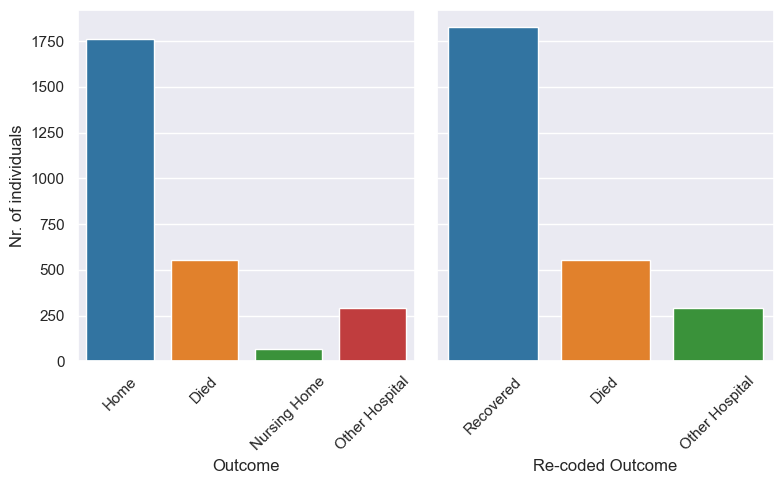

In [117]:
# Define custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Adjust these colors as needed

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)

# Plot original 'Outcome'
sns.countplot(ax=axes[0], x=transf_data['Outcome'], palette=colors)
axes[0].set(ylabel="Nr. of individuals", xlabel="Outcome")
axes[0].tick_params(axis='x', labelrotation=45)

# Plot recoded 'Outcome_Rec'
sns.countplot(ax=axes[1], x=transf_data['Outcome_Rec'], palette=colors)
axes[1].set(ylabel="", xlabel="Re-coded Outcome")
axes[1].tick_params(axis='x', labelrotation=45)

sns.set(font_scale=1)

plt.tight_layout()
plt.show()

Risk re-assessment

In [118]:
# Replace 'Outcome' column with 'Outcome_Rec' values
transf_data['Outcome'] = transf_data['Outcome_Rec']

# Drop the 'Outcome_Rec' column from the dataset
transf_data.drop(columns=['Outcome_Rec'], inplace=True)

In [119]:
display(HTML(risk_fk_table(qi_sets, original_data_re, transf_data).to_html()))

,Quasi-Identifiers,Risk (%) Original,Risk (%) Transformed,Reduced Risk,fk1 Original,fk1 Transformed
0,"['Age', 'Gender']",0.595238,0.595238,0.000000,16,16
1,"['Age', 'Gender', 'Outcome']",4.687500,3.683036,1.004464,126,99
2,"['Age', 'Gender', 'HospitalisationDays']",53.683036,53.683036,0.000000,1443,1443
3,"['Age', 'Gender', 'HospitalisationDays', 'Outcome']",70.647321,70.498512,0.148810,1899,1895
4,"['Age', 'Gender', 'DateOfFirstPositiveLabResult']",90.550595,90.550595,0.000000,2434,2434
5,"['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome']",95.498512,94.940476,0.558036,2567,2552
6,"['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome']",99.702381,99.702381,0.000000,2680,2680


### Transformation - quartile on HospitalisationDays

In [120]:
transf_data['HospitalisationDays'].describe()

count    2688.000000
mean       18.172619
std        27.450913
min         0.000000
25%         5.000000
50%        10.000000
75%        19.000000
max       456.000000
Name: HospitalisationDays, dtype: float64

In [121]:
transf_data['HospitalisationDays'].quantile(1)

np.float64(456.0)

In [122]:
# Define the quantiles
q1 = transf_data['HospitalisationDays'].quantile(0.25)
q2 = transf_data['HospitalisationDays'].quantile(0.5)
q3 = transf_data['HospitalisationDays'].quantile(0.75)
q4 = transf_data['HospitalisationDays'].quantile(1.0)

# Define the conditions for each quartile
conditions = [
    transf_data['HospitalisationDays'] <= q1,
    (transf_data['HospitalisationDays'] > q1) & (transf_data['HospitalisationDays'] <= q2),
    (transf_data['HospitalisationDays'] > q2) & (transf_data['HospitalisationDays'] <= q3),
    transf_data['HospitalisationDays'] > q3
]

# Define the corresponding transformations for each condition
choices = [q1, q2, q3, q4]

# Apply the transformation to 'Length of hospital stay'
transf_data['HospitalisationDays'] = np.select(conditions, choices, default=transf_data['HospitalisationDays'])

In [123]:
grp = transf_data.groupby(['HospitalisationDays']).size().reset_index(name='Count')
grp

,HospitalisationDays,Count
0,5.0,790
1,10.0,661
2,19.0,571
3,456.0,666


/var/folders/9w/t57sm1m50mz29c9_1rnvp2wh0000gn/T/ipykernel_37548/1127270924.py:28: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([ax1.get_ylabel(), ax2.get_ylabel()], labels=['Transformed','Original'], bbox_to_anchor=(0., 1, 0.96, -.05))


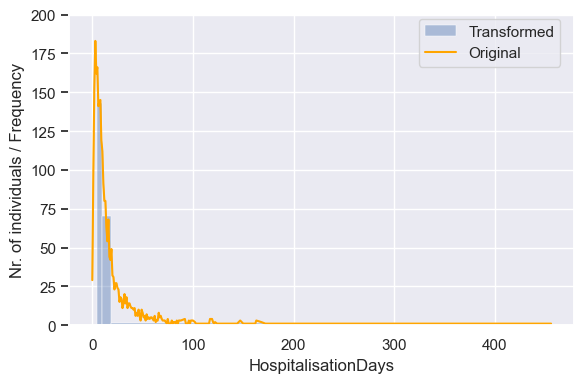

In [124]:
combined_days = pd.concat([original_data_re[['HospitalisationDays']], transf_data[['HospitalisationDays']]], axis=1)
combined_days.columns=['HospitalisationDays', 'HospitalisationDays_quantile']
combined_days['HospitalisationDays_count'] = combined_days.groupby('HospitalisationDays')['HospitalisationDays'].transform(len)

bins = np.sort(combined_days['HospitalisationDays_quantile'].unique())
#bins = np.insert(bins, len(bins), 0)

sns.set(font_scale=1)
fig, ax1 = plt.subplots(figsize=(6, 4))
sns.histplot(x=combined_days['HospitalisationDays'],
        bins=bins,
        stat='frequency',
        ax=ax1,
        alpha=0.4
        )
ax2 = ax1.twinx()       
sns.lineplot(data=combined_days,
           x='HospitalisationDays', 
           y='HospitalisationDays_count',
           ax=ax2,
           color='orange')

ax1.set_ylim([0, 200])
ax2.set_ylim([0, 200])
ax1.set_ylabel("Nr. of individuals / Frequency")
ax1.set_xlabel("HospitalisationDays")
ax2.get_yaxis().set_visible(False)
fig.legend([ax1.get_ylabel(), ax2.get_ylabel()], labels=['Transformed','Original'], bbox_to_anchor=(0., 1, 0.96, -.05))
plt.tight_layout()

In [125]:
display(HTML(risk_fk_table(qi_sets, original_data_re, transf_data).to_html()))

,Quasi-Identifiers,Risk (%) Original,Risk (%) Transformed,Reduced Risk,fk1 Original,fk1 Transformed
0,"['Age', 'Gender']",0.595238,0.595238,0.000000,16,16
1,"['Age', 'Gender', 'Outcome']",4.687500,3.683036,1.004464,126,99
2,"['Age', 'Gender', 'HospitalisationDays']",53.683036,5.431548,48.251488,1443,146
3,"['Age', 'Gender', 'HospitalisationDays', 'Outcome']",70.647321,16.108631,54.538690,1899,433
4,"['Age', 'Gender', 'DateOfFirstPositiveLabResult']",90.550595,90.550595,0.000000,2434,2434
5,"['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome']",95.498512,94.940476,0.558036,2567,2552
6,"['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome']",99.702381,98.660714,1.041667,2680,2652


### Transformation - generalise age every 5 years

In [126]:
# Set up bins with a 5-year interval
bins = list(range(min(transf_data['Age']), max(transf_data['Age']) + 5, 5))

# Generate labels for each bin as integer values
labels = [bins[i] for i in range(len(bins) - 1)]

# Use pd.cut to categorize 'Age' into bins
transf_data['Age'] = pd.cut(transf_data['Age'], bins=bins, labels=labels, include_lowest=True).astype(int)

/var/folders/9w/t57sm1m50mz29c9_1rnvp2wh0000gn/T/ipykernel_37548/4143008235.py:30: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([ax1.get_ylabel(), ax2.get_ylabel()], labels=['Transformed', 'Original'], bbox_to_anchor=(0., 1, 0.96, -.05))


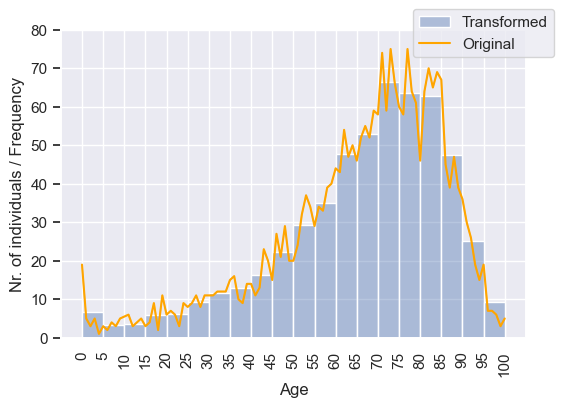

In [127]:
combined_ages = pd.concat([original_data_re[['Age']], transf_data[['Age']]], axis=1)
combined_ages.columns=['Age', 'Age5']
combined_ages['Age_count'] = combined_ages.groupby('Age')['Age'].transform(len)

bins = np.sort(combined_ages['Age5'].unique())
bins = np.insert(bins, len(bins), 100)

sns.set(font_scale=1)
fig, ax1 = plt.subplots(figsize=(6, 4))
sns.histplot(x=combined_ages['Age'],
        bins=bins,
        stat='frequency',
        ax=ax1,
        alpha=0.4
        )
ax2 = ax1.twinx()       
sns.lineplot(data=combined_ages,
           x='Age', 
           y='Age_count',
           ax=ax2,
           color='orange')

ax1.set_ylim([0, 80])
ax2.set_ylim([0, 80])
ax1.set_ylabel("Nr. of individuals / Frequency")
ax1.set_xlabel("Age")
ax1.set_xticks(bins)
ax1.tick_params(axis='x', rotation=90)
ax2.get_yaxis().set_visible(False)
fig.legend([ax1.get_ylabel(), ax2.get_ylabel()], labels=['Transformed', 'Original'], bbox_to_anchor=(0., 1, 0.96, -.05))
#plt.tight_layout()

In [128]:
display(HTML(risk_fk_table(qi_sets, original_data_re, transf_data).to_html()))

,Quasi-Identifiers,Risk (%) Original,Risk (%) Transformed,Reduced Risk,fk1 Original,fk1 Transformed
0,"['Age', 'Gender']",0.595238,0.000000,0.595238,16,0
1,"['Age', 'Gender', 'Outcome']",4.687500,0.595238,4.092262,126,16
2,"['Age', 'Gender', 'HospitalisationDays']",53.683036,0.520833,53.162202,1443,14
3,"['Age', 'Gender', 'HospitalisationDays', 'Outcome']",70.647321,2.418155,68.229167,1899,65
4,"['Age', 'Gender', 'DateOfFirstPositiveLabResult']",90.550595,64.657738,25.892857,2434,1738
5,"['Age', 'Gender', 'DateOfFirstPositiveLabResult', 'Outcome']",95.498512,78.571429,16.927083,2567,2112
6,"['Age', 'Gender', 'HospitalisationDays', 'DateOfFirstPositiveLabResult', 'Outcome']",99.702381,93.303571,6.398810,2680,2508


Frequency of fk > 1

In [129]:
fk = transf_data.copy()
qi = ['Age', 'Gender']
fk['fk'] = transf_data.groupby(qi, dropna=False)['Age'].transform(len)

In [130]:
fk.groupby('fk').size().reset_index(name='Count').head()

,fk,Count
0,7,14
1,10,10
2,11,22
3,14,14
4,15,30


Re-identification risk for each precondition

In [131]:
# Analyse the impact of transformations in precondition columns
conditon_qis = [
    ['Age', 'Gender', 'CANC'],
    ['Age', 'Gender', 'CEREBROVASCULAR'],
    ['Age', 'Gender', 'DIAB'],
    ['Age', 'Gender', 'KIDNEY'],
    ['Age', 'Gender', 'LIVER'],
    ['Age', 'Gender', 'LUNG_I'],
    ['Age', 'Gender', 'LUNG_II'],
    ['Age', 'Gender', 'HEART'],
    ['Age', 'Gender', 'TRANSP'],
    ['Age', 'Gender', 'OBESITY'],
    ['Age', 'Gender', 'SMOKING'],
    ['Age', 'Gender', 'NERVOUS']
]
risk_fk_table(conditon_qis, original_data, transf_data)

,Quasi-Identifiers,Risk (%) Original,Risk (%) Transformed,Reduced Risk,fk1 Original,fk1 Transformed
0,"['Age', 'Gender', 'CANC']",2.154858,0.148810,2.006048,59,4
1,"['Age', 'Gender', 'CEREBROVASCULAR']",1.716581,0.111607,1.604974,47,3
2,"['Age', 'Gender', 'DIAB']",1.278305,0.074405,1.203901,35,2
3,"['Age', 'Gender', 'KIDNEY']",1.460920,0.148810,1.312111,40,4
4,"['Age', 'Gender', 'LIVER']",1.607012,0.186012,1.421001,44,5
5,"['Age', 'Gender', 'LUNG_I']",1.314828,0.186012,1.128816,36,5
6,"['Age', 'Gender', 'LUNG_II']",1.972243,0.186012,1.786231,54,5
7,"['Age', 'Gender', 'HEART']",1.497443,0.186012,1.311431,41,5
8,"['Age', 'Gender', 'TRANSP']",1.460920,0.186012,1.274908,40,5
9,"['Age', 'Gender', 'OBESITY']",1.643535,0.037202,1.606333,45,1


### Transformation - add randomness in dates

In [132]:
transf_data['DateOfFirstPositiveLabResult'].nunique()

484

In [133]:
original_data_re['DateOfFirstPositiveLabResult'] = pd.to_datetime(original_data_re['DateOfFirstPositiveLabResult']).dt.date.astype('datetime64[ns]')

Noise [-3, 3]

In [134]:
np.random.seed(1)
# upper bound in randint is exclusive, hence 4
noise = np.random.randint(-3, 4, len(transf_data))  

# Apply noise
for i in range(len(transf_data)):
    transf_data.loc[i, 'DateOfFirstPositiveLabResult'] = transf_data.loc[i, 'DateOfFirstPositiveLabResult'] + datetime.timedelta(days=int(noise[i]))

In [135]:
transf_data['DateOfFirstPositiveLabResult'] = pd.to_datetime(transf_data['DateOfFirstPositiveLabResult'])

In [136]:
print(noise[0:10])

[ 2  0  1 -3 -2  0  2 -3 -3 -2]


In [137]:
len(noise[noise == 0])

375

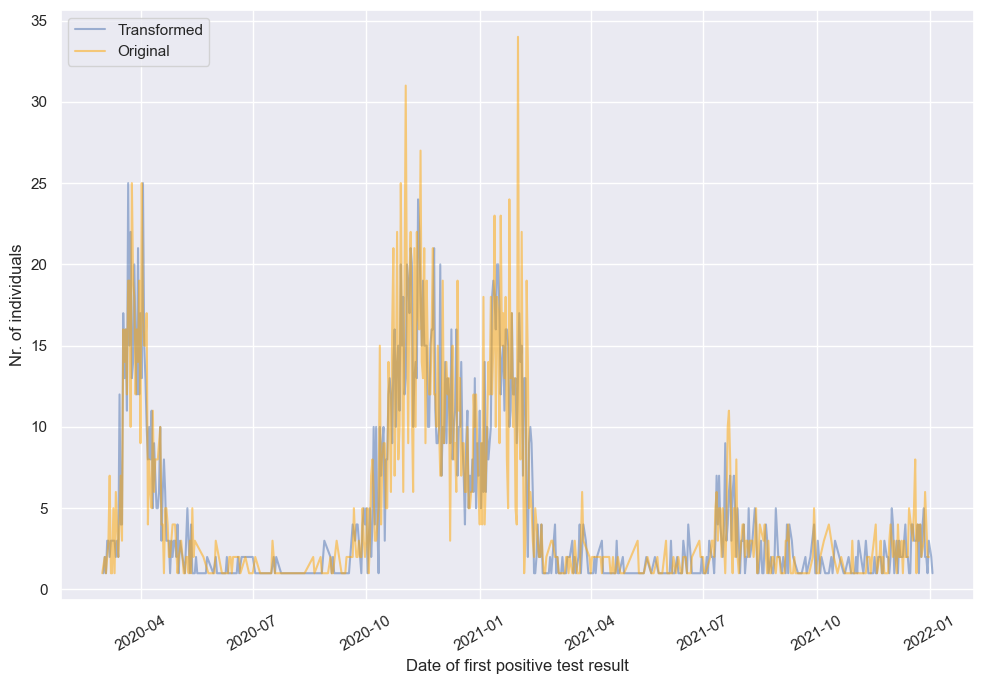

In [138]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 7))
date = original_data_re.groupby(['DateOfFirstPositiveLabResult']).size().reset_index(name='Count')
date2 = transf_data.groupby(['DateOfFirstPositiveLabResult']).size().reset_index(name='Count')
plt.plot(date2['DateOfFirstPositiveLabResult'], date2.Count, label='Transformed', alpha=0.5)
plt.plot(date['DateOfFirstPositiveLabResult'], date.Count, label='Original', color='orange', alpha=0.5)
plt.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=30)    
ax.set_ylabel("Nr. of individuals")
ax.set_xlabel("Date of first positive test result")
plt.tight_layout()

In [139]:
transf_data['DateOfFirstPositiveLabResult'].min(), transf_data['DateOfFirstPositiveLabResult'].max()

(Timestamp('2020-03-02 00:00:00'), Timestamp('2022-01-03 00:00:00'))

### Risk re-assessment with record linkage

In [ ]:
def record_linkage(df_protected, df_original, cols):
    # Set up indexer and generate candidate pairs
    indexer = recordlinkage.Index()
    indexer.full()
    candidates = indexer.index(df_protected, df_original)
    print("Number of candidate pairs:", len(candidates))

    # Initialize comparer
    compare = recordlinkage.Compare()
    
    # Dynamically add comparisons based on column data types
    for idx, col in enumerate(cols):
        # Numeric Comparison
        if pd.api.types.is_numeric_dtype(df_protected[col]):
            #A smaller scale value makes the comparison more sensitive to small differences, while a larger scale value makes it more tolerant.
            compare.numeric(col, col, method='gauss', scale=5, offset=0, label=col)

        # String Comparison
        elif pd.api.types.is_string_dtype(df_protected[col]):
            compare.string(col, col, method='levenshtein', threshold=0.75, label=col)

        # Date Comparison
        elif pd.api.types.is_datetime64_any_dtype(df_protected[col]):
            compare.date(col, col, swap_month_day=1, label=col)
        
        # Specific exact comparison for "Gender" column
        elif col.lower() == "gender" or col.lower() == "sex":
            compare.exact(col, col, label=col)

        # Catch-all for other types
        else:
            print(f"Column '{col}' has unsupported data type for comparison.")

    # Compute similarity scores
    return compare.compute(candidates, df_protected, df_original)

In [67]:
len(transf_data)*len(original_data_re)

7225344

In [79]:
transf_data['Outcome'] = transf_data.Outcome.astype(str)

In [80]:
rl = record_linkage(transf_data, original_data_re, qi_sets[6])

Number of candidate pairs: 7225344
Gender
Outcome


/Users/taniacarvalho/.local/share/virtualenvs/deIdentification-CovidData-yZrquX0i/lib/python3.10/site-packages/recordlinkage/compare.py:414: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  c[


In [81]:
rl

Age  Gender  HospitalisationDays  \
0    0     7.791646e-01     1.0             0.972655   
     1     1.695755e-01     1.0             0.972655   
     2     3.685673e-01     0.0             0.895025   
     3     8.268997e-04     1.0             0.368567   
     4     1.058432e-01     0.0             0.257028   
...                 ...     ...                  ...   
2687 2683  4.777993e-50     0.0             0.009227   
     2684  1.732995e-38     1.0             0.004364   
     2685  5.745443e-22     1.0             0.779165   
     2686  3.317578e-26     1.0             0.779165   
     2687  9.726549e-01     1.0             1.000000   

           DateOfFirstPositiveLabResult  Outcome  
0    0                              0.0      0.0  
     1                              0.0      0.0  
     2                              0.0      0.0  
     3                              0.0      0.0  
     4                              0.0      0.0  
...                                 ...      ...  
2687 2683                           0.0      0.0  
     2684                           0.0      0.0  
     2685                           0.0      0.0  
     2686                           0.0      0.0  
     2687                           0.0      0.0  

[7225344 rows x 5 columns]

In [82]:
# Filter rows where the sum of similarity scores is greater than 1
potential_matches = rl[rl.sum(axis=1) > 1].reset_index()

# Calculate a total score for each potential match across the selected columns by index
potential_matches['Score'] = potential_matches.iloc[:, 2:].sum(axis=1)

In [83]:
# 5*10**(-1) because of generalisation in age
vars3 = potential_matches[(potential_matches['Age'] >=5*10**(-1)) & (potential_matches['Gender'] == 1) & (potential_matches['DateOfFirstPositiveLabResult'] == 1)]

In [84]:
vars3

,level_0,level_1,Age,Gender,HospitalisationDays,DateOfFirstPositiveLabResult,Outcome,Score
1559,1,1,0.779165,1.0,9.726549e-01,1.0,1.0,4.751820
1861,1,448,0.895025,1.0,3.491522e-02,1.0,0.0,2.929940
2118,1,813,0.641713,1.0,9.726549e-01,1.0,0.0,3.614368
2383,1,1216,0.500000,1.0,9.726549e-01,1.0,0.0,3.472655
3103,1,2307,0.500000,1.0,1.695755e-01,1.0,1.0,3.669576
...,...,...,...,...,...,...,...,...
4032541,2673,2672,0.779165,1.0,1.058432e-01,1.0,0.0,2.885008
4042525,2680,2065,0.500000,1.0,9.726549e-01,1.0,0.0,3.472655
4043858,2681,2174,1.000000,1.0,6.417129e-01,1.0,0.0,3.641713
4048110,2684,1885,0.779165,1.0,1.336382e-51,1.0,0.0,2.779165


In [86]:
transf_data[['Age', 'Gender', 'DateOfFirstPositiveLabResult']].loc[1]

Age                                              80
Gender                                            F
DateOfFirstPositiveLabResult    2020-03-31 00:00:00
Name: 1, dtype: object

In [87]:
original_data_re[['Age', 'Gender', 'DateOfFirstPositiveLabResult']].loc[2307]

Age                                              85
Gender                                            F
DateOfFirstPositiveLabResult    2020-03-31 00:00:00
Name: 2307, dtype: object

In [88]:
freqs = vars3.groupby('level_0').size().reset_index(name='Count')
max_risk = len(freqs[freqs.Count == 1])

(max_risk * 100) / len(transf_data)

25.40922619047619

In [90]:
vars4 = potential_matches[(potential_matches['Age'] >= 5*10**(-1)) & (potential_matches['Gender'] == 1) & (potential_matches['DateOfFirstPositiveLabResult'] == 1) & (potential_matches['Outcome'] == 1)]

In [91]:
freqs = vars4.groupby('level_0').size().reset_index(name='Count')
max_risk = len(freqs[freqs.Count == 1])

(max_risk * 100) / len(transf_data)

7.998511904761905

In [92]:
vars5 = potential_matches[(potential_matches['Age'] >= 5*10**(-1)) & (potential_matches['Gender'] == 1) & (potential_matches['DateOfFirstPositiveLabResult'] == 1) & (potential_matches['Outcome'] == 1) & (potential_matches['HospitalisationDays'] == 1)]

In [93]:
freqs = vars5.groupby('level_0').size().reset_index(name='Count')
max_risk = len(freqs[freqs.Count == 1])

(max_risk * 100) / len(transf_data)

1.0416666666666667

### Save de-identified data

In [ ]:

del transf_data['ReincidenceHospitalisation']
del transf_data['RecordId']
del transf_data['AgeMonth']
del transf_data['DateOfHospitalisation']

In [ ]:
#transf_data.to_csv('Deidentified_data.csv', index=False)